# Hypothesis Testing

In this notebook, we are testing 2 hypothesis related to our target variable in order to affirm our assumptions:
1. there's association between **defaults** in *current* loans, and having **any late payments** in *previous* loans.
2. The proportion of **Annuity-To-Income** is different for the *default* and *repaid* loans.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import sys
dir_path = "/content/drive/MyDrive/Colab Notebooks/LoanDefaults/"
sys.path.append(dir_path + "utils/")

In [3]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import plot_functions as my
import helper as hl

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 125)

pd.set_option("display.float_format", lambda x: "%.3f" % x)

In [4]:
muted = ["#ee854a", "#4878d0"]

style_params = {"hue_order": [True, False], "palette": muted}

In [5]:
loans = pd.read_pickle(dir_path + "data/loans_agg.pkl")
loans = loans[loans["set"]=="train"]

id_cols = []
for col in loans:
    if "SK_ID_CURR" in col or "SK_ID_PREV" in col or "SK_ID_BUREAU" in col:
        if col != "SK_ID_CURR":
            id_cols.append(col)
loans.drop(columns=id_cols, inplace=True)

print(loans.shape)
loans.head(3)

(276759, 1129)


,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EMERGENCYSTATE_MODE_MISSING,DAYS_EMPLOYED_ANOMALY,set,INCOME_TO_CREDIT,ANNUITY_TO_INCOME,PAYMENT_RATE,CREDIT_TO_GOODS,EMPLOYMENT_RATE,COUNT(prev_loans),MAX(prev_loans.AMT_ANNUITY),MAX(prev_loans.AMT_APPLICATION),MAX(prev_loans.AMT_CREDIT),MAX(prev_loans.AMT_DOWN_PAYMENT),MAX(prev_loans.AMT_GOODS_PRICE),MAX(prev_loans.CNT_PAYMENT),MAX(prev_loans.DAYS_DECISION),MAX(prev_loans.DAYS_FIRST_DRAWING),MAX(prev_loans.DAYS_FIRST_DUE),MAX(prev_loans.DAYS_LAST_DUE),MAX(prev_loans.DAYS_LAST_DUE_1ST_VERSION),MAX(prev_loans.DAYS_TERMINATION),MAX(prev_loans.NAME_YIELD_GROUP),MAX(prev_loans.NFLAG_INSURED_ON_APPROVAL),MAX(prev_loans.NFLAG_LAST_APPL_IN_DAY),MAX(prev_loans.RATE_DOWN_PAYMENT),MAX(prev_loans.RATE_INTEREST_PRIMARY),MAX(prev_loans.RATE_INTEREST_PRIVILEGED),MAX(prev_loans.SELLERPLACE_AREA),MEAN(prev_loans.AMT_ANNUITY),MEAN(prev_loans.AMT_APPLICATION),MEAN(prev_loans.AMT_CREDIT),MEAN(prev_loans.AMT_DOWN_PAYMENT),MEAN(prev_loans.AMT_GOODS_PRICE),MEAN(prev_loans.CNT_PAYMENT),MEAN(prev_loans.DAYS_DECISION),MEAN(prev_loans.DAYS_FIRST_DRAWING),MEAN(prev_loans.DAYS_FIRST_DUE),MEAN(prev_loans.DAYS_LAST_DUE),MEAN(prev_loans.DAYS_LAST_DUE_1ST_VERSION),MEAN(prev_loans.DAYS_TERMINATION),MEAN(prev_loans.NAME_YIELD_GROUP),MEAN(prev_loans.NFLAG_INSURED_ON_APPROVAL),MEAN(prev_loans.NFLAG_LAST_APPL_IN_DAY),MEAN(prev_loans.RATE_DOWN_PAYMENT),MEAN(prev_loans.RATE_INTEREST_PRIMARY),MEAN(prev_loans.RATE_INTEREST_PRIVILEGED),MEAN(prev_loans.SELLERPLACE_AREA),MIN(prev_loans.AMT_ANNUITY),MIN(prev_loans.AMT_APPLICATION),MIN(prev_loans.AMT_CREDIT),MIN(prev_loans.AMT_DOWN_PAYMENT),MIN(prev_loans.AMT_GOODS_PRICE),MIN(prev_loans.CNT_PAYMENT),MIN(prev_loans.DAYS_DECISION),MIN(prev_loans.DAYS_FIRST_DRAWING),MIN(prev_loans.DAYS_FIRST_DUE),MIN(prev_loans.DAYS_LAST_DUE),MIN(prev_loans.DAYS_LAST_DUE_1ST_VERSION),MIN(prev

In [6]:
nulls_info = hl.get_null_info(loans)
nulls_info.set_index("Column", inplace=True)

most_nulls = nulls_info.T.sort_values(by="As Percentage", ascending=False)
print("In this dataset -",len(most_nulls[most_nulls["As Percentage"] >= 50]),
      "out of", loans.shape[1], "columns have at least half rows missing.")

display(most_nulls.head(4))

null_cols = most_nulls[most_nulls["As Percentage"] >= 50].index
loans.drop(columns=null_cols, inplace=True)
print("\nShape of our working dataframe:",loans.shape)

In this dataset - 568 out of 1129 columns have at least half rows missing.


Column,Null Counts,As Percentage
MIN(credit_card.prev_loans.NAME_YIELD_GROUP),276759.000,100.000
MAX(credit_card.prev_loans.NAME_YIELD_GROUP),276759.000,100.000
MEAN(credit_card.prev_loans.RATE_INTEREST_PRIMARY),276759.000,100.000
MEAN(credit_card.prev_loans.RATE_INTEREST_PRIVILEGED),276759.000,100.000



Shape of our working dataframe: (276759, 561)


# Hypothesis Nr 1. - Defaults in previous applications and defaults

**$H_{1N}$**: There is no association between being late on previous loan payments and current loan defaults.

**$H_{1A}$**: There is an association between being late in previous loan payments and current loan defaults.

**Population**: All loan applicants in the training dataset that had previous applications.
  * Group 1 (No late payments): ~125k loans
  * Group 2 (At least one late payment): ~135k loans

**_Statistical test_**: Chi-Squared test of independence.

**_Required alpha_**: 0.001, as we have quite a large sample.


In [7]:
late_df = loans[["MAX(inst_paym.days_late)", "TARGET"]].copy().dropna()
late_df.columns = ["days_late", "default"]
late_df["prev_late"] = late_df["days_late"] > 0

late_df["prev_late"] = late_df["prev_late"].replace({False: "On Time", True: "Late"})
late_df["default"] = late_df["default"].replace({False: "Paid Off", True: "Default"})

print("Group 1 (On Time):", late_df[late_df["prev_late"]=="On Time"].shape[0])
print("Group 2 (Late):", late_df[late_df["prev_late"]=="Late"].shape[0])

n = loans.shape[0]

late_df.head(3)

Group 1 (On Time): 125229
Group 2 (Late): 135205


,days_late,default,prev_late
SK_ID_CURR,,,
371646,0.000,Paid Off,On Time
139700,1.000,Paid Off,Late
407492,3.000,Paid Off,Late


In [8]:
contingency_table = pd.crosstab(late_df["prev_late"], late_df["default"])

print(contingency_table, "\n")

chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-squared: {chi2:.2f}")
print(f"P-value: {p_value:.8f}")

alpha = 0.001
print(f"Reject the null hypothesis: {p_value < alpha}")

default    Default  Paid Off
prev_late                   
Late         12898    122307
On Time       8427    116802 

Chi-squared: 682.63
P-value: 0.00000000
Reject the null hypothesis: True


With a p-value below 0.001, we reject the null hypothesis, and state that there is an association between being late on previous loan payments and current loan defaults.

Now, let's take a look and how large the differences in proportions are.

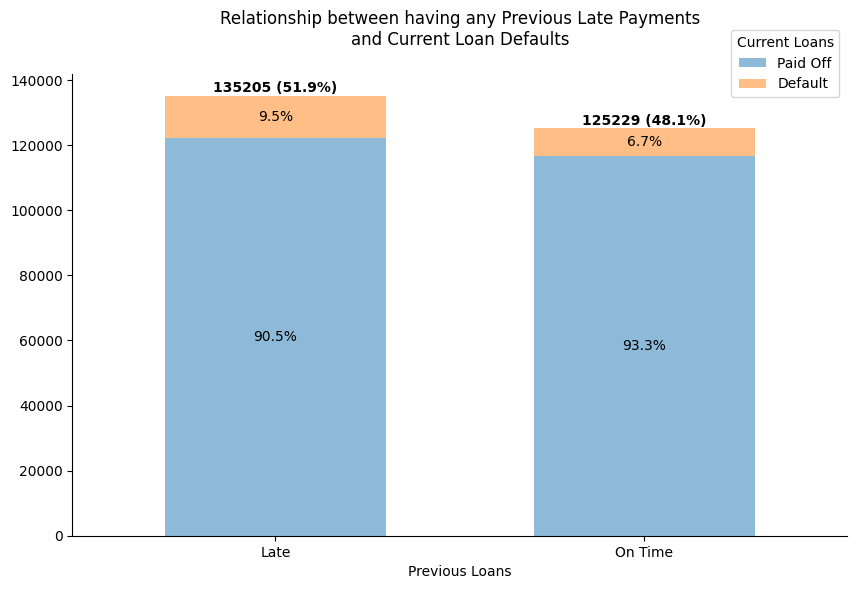

In [9]:
late_df["default"] = pd.Categorical(late_df["default"], ["Paid Off", "Default"])
late_df.sort_values(by='default', ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))

my.stacked_barchart(late_df, category_col="prev_late", target_col="default",
                    ax=ax, x_label="Previous Loans")

plt.title(
    "Relationship between having any Previous Late Payments\nand Current Loan Defaults\n"
    )
plt.legend(title="Current Loans", loc=(0.85, 0.95))

plt.show()

Looking at the stacked barchart above, there is visible difference. The likelihood of default for a lender with previous late payments is ~40% higher than for the lenders that never missed an installment payment.

Let's test the strength of the association effect with Cramer's V.

In [10]:
# New code
def cramer_v(chi2, n, phi2, r, k):
    # Correct phi2 for bias
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    rcorr = r - (r-1)**2/(n-1)
    kcorr = k - (k-1)**2/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

phi2 = chi2 / n

# Calculating Cramer's V
v = cramer_v(chi2, n, phi2, dof+1, 2) # dof+1 for rows, 2 for columns as per contingency table

print(f"Cramer's V: {v:.4f}")


Cramer's V: 0.0496


The Cramer's V test indicates the strength of association with value between 0 and 1. In our case, the values is very low, indicating that the effect is of low strength.

# Hypothesis Nr 2. - Mean Annuity-to-Income in Defaulted and Paid Off Loans

**$H_{2N}$**: There is no difference in the mean Annuity-to-Income ratio between loans that defaulted and those that did not.

**$H_{2A}$**: There is a statistically significant difference in the mean Annuity-to-Income ratio between loans that defaulted and those that did not.

**Population**: All loan applicants in the training dataset where Annuity and Income was not missing.
  * Group 1 (Defaulted): ~22k
  * Group 2 (Not Defaulted): ~254k.


**_Statistical test_**: two-sample t-test.

**_Required alpha_**: 0.001, as we have quite a large sample.

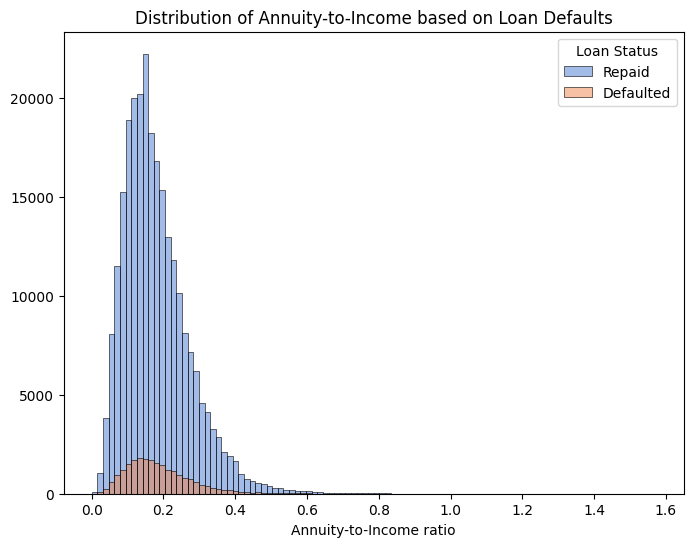

In [11]:
plt.figure(figsize=(8, 6))

sns.histplot(data=loans, x="ANNUITY_TO_INCOME", bins=100, alpha=0.5,
             hue="TARGET", **style_params)

plt.xlabel("Annuity-to-Income ratio")
plt.ylabel("")
plt.title("Distribution of Annuity-to-Income based on Loan Defaults")

plt.legend(title="Loan Status", loc="upper right", labels=["Repaid", "Defaulted"])

plt.show()

In [12]:
defaulted = loans[loans["TARGET"] == True]["ANNUITY_TO_INCOME"].dropna()
not_defaulted = loans[loans["TARGET"] == False]["ANNUITY_TO_INCOME"].dropna()

t_stat, p_value = stats.ttest_ind(defaulted, not_defaulted)
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")

mean_defaulted = np.mean(defaulted)
mean_not_defaulted = np.mean(not_defaulted)
mean_difference = mean_defaulted - mean_not_defaulted
print(f"Means: defaulted {mean_defaulted:.4f}, not defaulted {mean_not_defaulted:.4f}")

n_defaulted = len(defaulted)
n_not_defaulted = len(not_defaulted)

print(f"Sample sizes: defaulted {n_defaulted}, not defaulted {n_not_defaulted}")

var_defaulted = np.var(defaulted, ddof=1)
var_not_defaulted = np.var(not_defaulted, ddof=1)

std_err_defaulted = np.sqrt(var_defaulted) / np.sqrt(n_defaulted)
std_err_not_defaulted = np.sqrt(var_not_defaulted) / np.sqrt(n_not_defaulted)
std_err_dif = np.sqrt(var_defaulted/n_defaulted + var_not_defaulted/n_not_defaulted)

ci_lower, ci_upper = stats.norm.interval(0.95, loc=mean_difference, scale=std_err_dif)
ci_defaulted = stats.norm.interval(0.95, loc=mean_defaulted, scale=std_err_defaulted)
ci_not_defaulted = stats.norm.interval(0.95, loc=mean_not_defaulted, scale=std_err_not_defaulted)

print(f"95% confidence interval for the difference in means: {ci_lower:.4f}, {ci_upper:.4f}")

alpha = 0.001
print(f"Reject the null hypothesis: {p_value < alpha}")


t-statistic: 7.6079871057424935
p-value: 2.792703054696217e-14
Means: defaulted 0.1856, not defaulted 0.1806
Sample sizes: defaulted 22342, not defaulted 254407
95% confidence interval for the difference in means: 0.0037, 0.0063
Reject the null hypothesis: True


In [13]:
print("Difference in means:", str(round(mean_difference / mean_not_defaulted * 100, 2)) + "%")

Difference in means: 2.78%


With a p-value much lower than our threshold, and 0 being outside the confidence interval for the difference of means - we **reject the null hypothesis** and state that the mean Annuity-To-Income is in fact different between the two groups.

The direction of the difference also makes sense, as the means indicate that defaulters are obligated to use a larger proportion of their income to pay their obligations. The difference in this case is quite small, around 2.8%

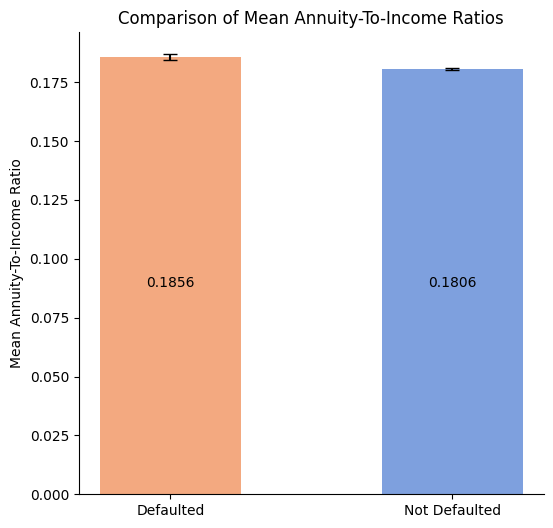

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.bar("Defaulted", mean_defaulted, yerr=[mean_defaulted - ci_defaulted[0]],
       capsize=5, color=muted[0], align="center", width=0.5, alpha=0.7)

ax.bar("Not Defaulted", mean_not_defaulted,
       yerr=[mean_not_defaulted - ci_not_defaulted[0]], capsize=5,
       color=muted[1], align="center", width=0.5, alpha=0.7)

ax.set_ylabel("Mean Annuity-To-Income Ratio")
ax.set_title("Comparison of Mean Annuity-To-Income Ratios")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.text(0, mean_defaulted / 2, f'{mean_defaulted:.4f}', ha="center", va="top")
ax.text(1, mean_defaulted / 2, f'{mean_not_defaulted:.4f}', ha="center", va="top")

plt.show()

Due to a large sample size and the difference in means being so small, we have to zoom in on the chart to see differences.

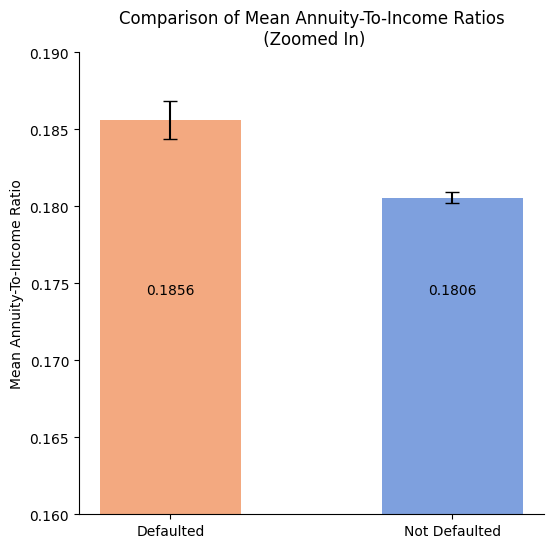

In [15]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.bar("Defaulted", mean_defaulted, yerr=[mean_defaulted - ci_defaulted[0]],
       capsize=5, color=muted[0], align="center", width=0.5, alpha=0.7)

ax.bar("Not Defaulted", mean_not_defaulted,
       yerr=[mean_not_defaulted - ci_not_defaulted[0]], capsize=5,
       color=muted[1], align="center", width=0.5, alpha=0.7)

ax.set_ylabel("Mean Annuity-To-Income Ratio")
ax.set_title("Comparison of Mean Annuity-To-Income Ratios\n (Zoomed In)")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.text(0, 0.175, f'{mean_defaulted:.4f}', ha="center", va="top")
ax.text(1, 0.175, f'{mean_not_defaulted:.4f}', ha="center", va="top")

plt.ylim(0.16, 0.19)

plt.show()

Although the differences are statistically significant and the Confidence Intervals do not overlap, the differences are quite small: the Annuity-To-Income ratio is higher by about 2.8% for the defaulted loans then for the non-defaulted loans.

Practically speaking, this could mean that:
* Even small changes to Annuity-to-Income could influence loan defaults; or
* Annuity-to-Income ratio is of low importance and affect on loan default: other factors most likely have a stronger affect on loan default.